## Fit AuotoARIMA

In [1]:
import pandas as pd


# List of file paths
file_paths = ['rnd/2013-7/306.csv', 'rnd/2013-8/306.csv', 'rnd/2013-9/306.csv']

# Initialize an empty list to store each DataFrame
dataframes = []

# Loop through each file path, load the data, and append to the list
for file_path in file_paths:
    df = pd.read_csv(file_path, sep=';\t', engine='python')  # Load each file
    if 'rnd/2013-7' in file_path:
        start_date = "2013-07-01 00:00:00"
    elif 'rnd/2013-8' in file_path:
        start_date = "2013-08-01 00:00:00"
    elif 'rnd/2013-9' in file_path:
        start_date = "2013-09-01 00:00:00"
    start_timestamp = pd.to_datetime(start_date)
    df['timestamp'] = [start_timestamp + pd.Timedelta(minutes=5*i) for i in range(len(df))]
    dataframes.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into a single DataFrame
data = pd.concat(dataframes, ignore_index=True)

# Adjusting the timestamp to reflect the correct year and month ("2013-08")


# Creating the two univariate datasets with the corrected timestamp
cpu_usage_dataset_with_corrected_timestamp = data[['timestamp', 'CPU usage [%]']].copy()
cpu_usage_dataset_with_corrected_timestamp  = cpu_usage_dataset_with_corrected_timestamp.rename(columns={'CPU usage [%]': 'y', 'timestamp': 'ds'})

#Resample to hours
cpu_usage_dataset_with_corrected_timestamp['ds'] = pd.to_datetime(cpu_usage_dataset_with_corrected_timestamp['ds'])
cpu_usage_dataset_with_corrected_timestamp.set_index('ds', inplace=True)
cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.resample('H').mean()

cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.reset_index()


cpu_usage_dataset_with_corrected_timestamp['unique_id'] = 'VM306'

cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.tail(7*24) #Select last 7 days of data to make example faster

# Displaying the first few rows of each corrected dataset to verify
cpu_usage_dataset_with_corrected_timestamp




,ds,y,unique_id
2016,2013-09-23 00:00:00,55.133333,VM306
2017,2013-09-23 01:00:00,55.125000,VM306
2018,2013-09-23 02:00:00,55.155556,VM306
2019,2013-09-23 03:00:00,55.261111,VM306
2020,2013-09-23 04:00:00,55.144444,VM306
...,...,...,...
2179,2013-09-29 19:00:00,55.133333,VM306
2180,2013-09-29 20:00:00,55.102778,VM306
2181,2013-09-29 21:00:00,55.211111,VM306
2182,2013-09-29 22:00:00,55.147222,VM306


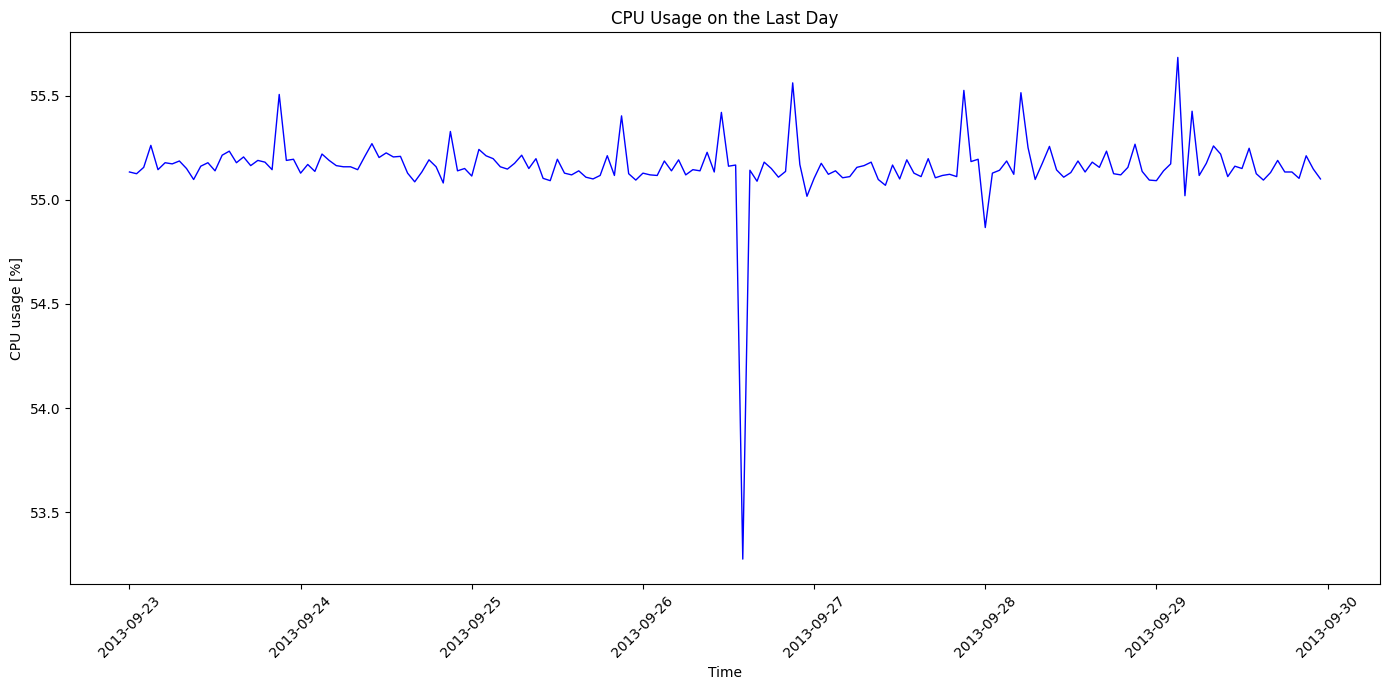

In [2]:
import matplotlib.pyplot as plt

# Plotting the CPU usage data for the last day
plt.figure(figsize=(14, 7))
plt.plot(cpu_usage_dataset_with_corrected_timestamp['ds'], cpu_usage_dataset_with_corrected_timestamp['y'], color='blue', linewidth=1)
plt.title('CPU Usage on the Last Day')
plt.xlabel('Time')
plt.ylabel('CPU usage [%]')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [3]:
from statsforecast import StatsForecast



/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from statsforecast.models import (
    AutoARIMA,
    AutoTheta,
    AutoETS,
    AutoCES,
    SeasonalNaive,
    WindowAverage,
    SeasonalWindowAverage,
    Naive
)

models = [
    AutoARIMA(season_length=24),
    AutoTheta(season_length=24),
    AutoETS(season_length=24),
    AutoCES(season_length=24),
    SeasonalNaive(season_length=24), 
    WindowAverage(window_size=24), 
    SeasonalWindowAverage(window_size=1, season_length=24),
    Naive()
]

sf = StatsForecast( 
    models=models,
    freq='H',
    fallback_model = SeasonalNaive(season_length=24),
    n_jobs=-1,
)

#forecasts_df = sf.forecast(df=cpu_usage_dataset_with_corrected_timestamp, h=48, level=[90])
#forecasts_df

In [5]:
#sf.plot(cpu_usage_dataset_with_corrected_timestamp,forecasts_df)


In [6]:
crossvaldation_df = sf.cross_validation(
    df=cpu_usage_dataset_with_corrected_timestamp,
    h=24,
    step_size=48,
    n_windows=1
)

/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [7]:
crossvaldation_df

,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,SeasonalNaive,WindowAverage,SeasWA,Naive
unique_id,,,,,,,,,,,
VM306,2013-09-29 00:00:00,2013-09-28 23:00:00,55.091667,55.129585,55.160892,55.154892,55.063522,54.866665,55.162716,54.866665,55.094444
VM306,2013-09-29 01:00:00,2013-09-28 23:00:00,55.138889,55.129532,55.160763,55.154892,55.171417,55.127777,55.162716,55.127777,55.094444
VM306,2013-09-29 02:00:00,2013-09-28 23:00:00,55.172222,55.129482,55.160633,55.154892,55.131279,55.141666,55.162716,55.141666,55.094444
VM306,2013-09-29 03:00:00,2013-09-28 23:00:00,55.683334,55.129433,55.160503,55.154892,55.081753,55.186111,55.162716,55.186111,55.094444
VM306,2013-09-29 04:00:00,2013-09-28 23:00:00,55.019444,55.129379,55.160374,55.154892,55.135159,55.122223,55.162716,55.122223,55.094444
VM306,2013-09-29 05:00:00,2013-09-28 23:00:00,55.424999,55.129330,55.160244,55.154892,55.207291,55.513889,55.162716,55.513889,55.094444
VM306,2013-09-29 06:00:00,2013-09-28 23:00:00,55.116665,55.129280,55.160114,55.154892,55.147995,55.250000,55.162716,55.250000,55.094444
VM306,2013-09-29 07:00:00,2013-09-28 23:00:00,55.174999,55.129227,55.159985,55.154892,55.114239,55.097420,55.162716,55.097420,55.094444
VM306,2013-09-29 08:00:00,2013-09-28 23:00:00,55.258335,55.129177,55.159855,55.154892,55.152714,55.174999,55.162716,55.174999,55.094444


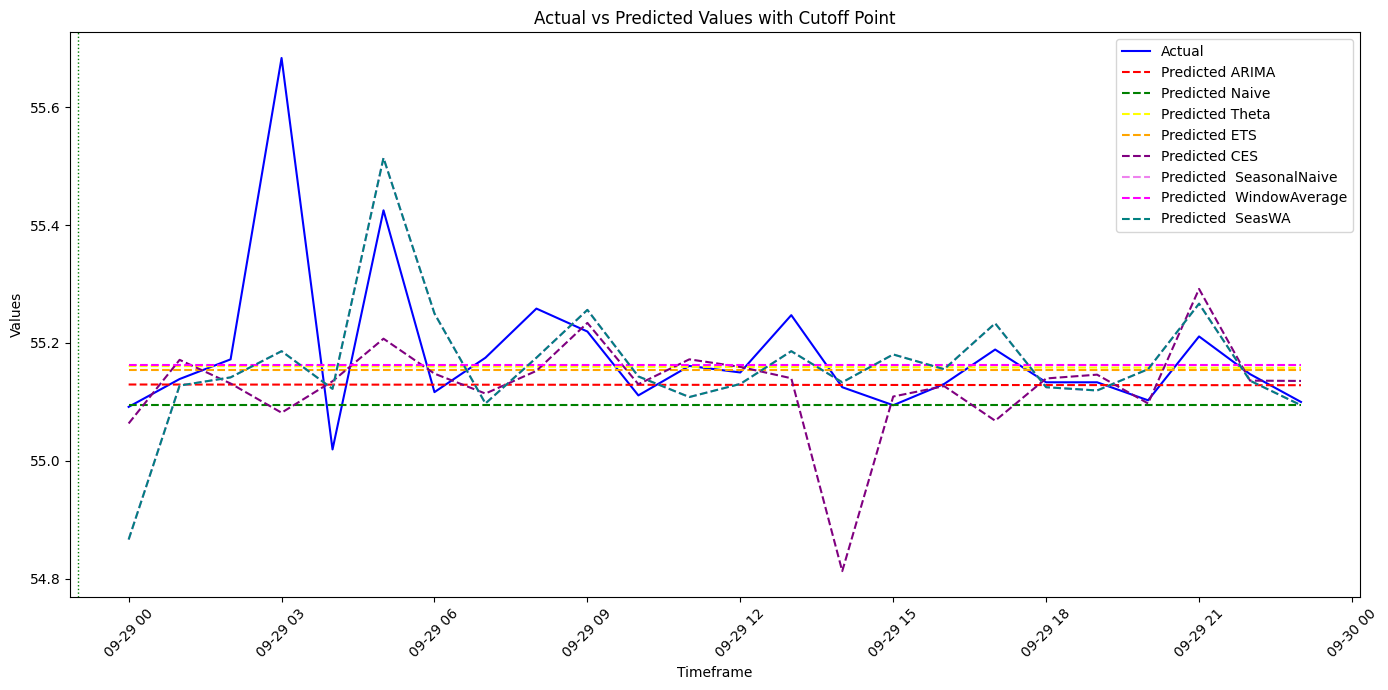

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [9]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

# Initialize and fit the Prophet model
model = Prophet()

model.fit(cpu_usage_dataset_with_corrected_timestamp)

Importing plotly failed. Interactive plots will not work.
17:53:56 - cmdstanpy - INFO - Chain [1] start processing
17:53:56 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
df_cv = cross_validation(model, horizon='2 days', initial='3 days')

  0%|          | 0/2 [00:00<?, ?it/s]

17:53:56 - cmdstanpy - INFO - Chain [1] start processing
17:53:57 - cmdstanpy - INFO - Chain [1] done processing
17:53:57 - cmdstanpy - INFO - Chain [1] start processing
17:53:57 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
pd.set_option('display.max_rows', 97)
df_cv = df_cv.sort_values(by='ds')
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-09-27 00:00:00,55.038536,54.792102,55.290636,55.102778,2013-09-26 23:00:00
1,2013-09-27 01:00:00,55.012242,54.770237,55.270647,55.175000,2013-09-26 23:00:00
2,2013-09-27 02:00:00,55.030213,54.771177,55.298894,55.122222,2013-09-26 23:00:00
3,2013-09-27 03:00:00,55.071243,54.809491,55.341129,55.138889,2013-09-26 23:00:00
4,2013-09-27 04:00:00,55.093601,54.856043,55.333430,55.105556,2013-09-26 23:00:00
5,2013-09-27 05:00:00,55.073224,54.842926,55.321083,55.111111,2013-09-26 23:00:00
6,2013-09-27 06:00:00,55.027463,54.782417,55.279073,55.155556,2013-09-26 23:00:00
7,2013-09-27 07:00:00,55.000062,54.755459,55.246469,55.163889,2013-09-26 23:00:00
8,2013-09-27 08:00:00,55.019612,54.776162,55.263716,55.180556,2013-09-26 23:00:00
9,2013-09-27 09:00:00,55.070050,54.837647,55.328413,55.097222,2013-09-26 23:00:00


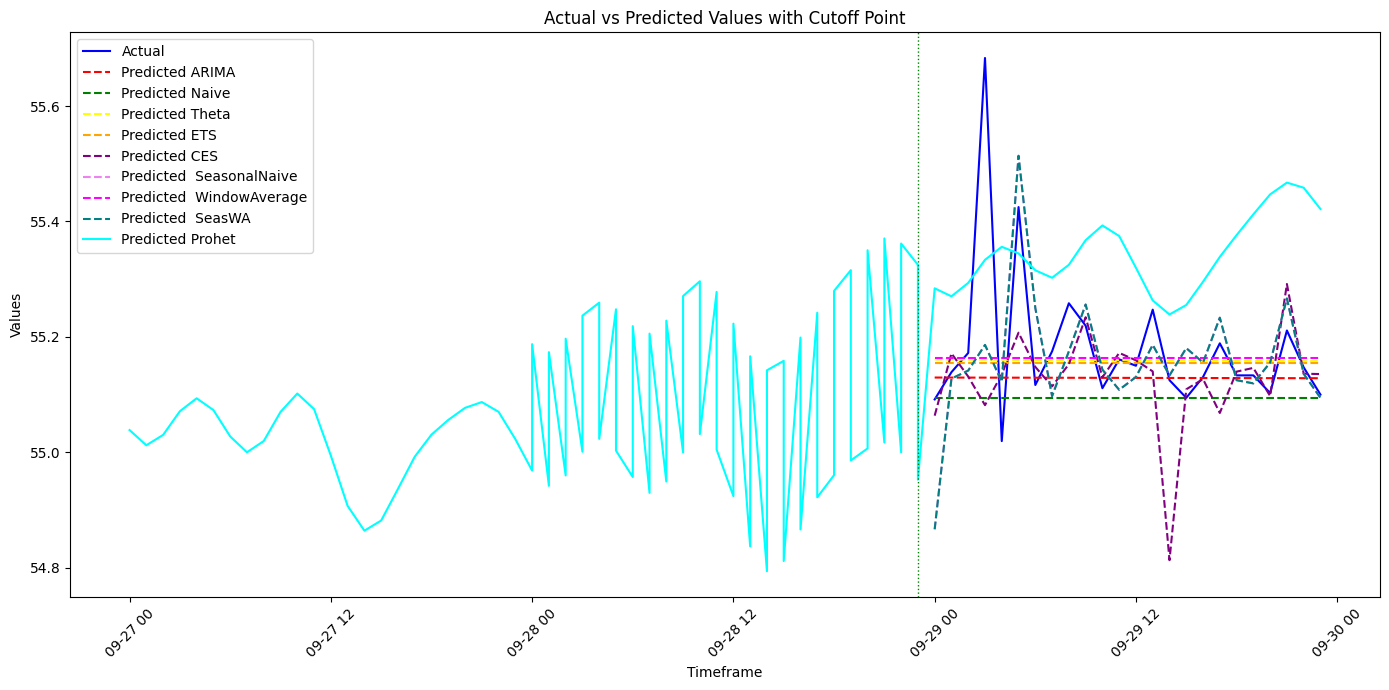

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

plt.plot(df_cv['ds'], df_cv['yhat'], label='Predicted Prohet', color='cyan', linestyle='-')


for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [13]:
crossvaldation_df = crossvaldation_df.reset_index()
crossvaldation_df['prophet'] = df_cv['yhat']
crossvaldation_df

,unique_id,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet
0,VM306,2013-09-29 00:00:00,2013-09-28 23:00:00,55.091667,55.129585,55.160892,55.154892,55.063522,54.866665,55.162716,54.866665,55.094444,55.038536
1,VM306,2013-09-29 01:00:00,2013-09-28 23:00:00,55.138889,55.129532,55.160763,55.154892,55.171417,55.127777,55.162716,55.127777,55.094444,55.012242
2,VM306,2013-09-29 02:00:00,2013-09-28 23:00:00,55.172222,55.129482,55.160633,55.154892,55.131279,55.141666,55.162716,55.141666,55.094444,55.030213
3,VM306,2013-09-29 03:00:00,2013-09-28 23:00:00,55.683334,55.129433,55.160503,55.154892,55.081753,55.186111,55.162716,55.186111,55.094444,55.071243
4,VM306,2013-09-29 04:00:00,2013-09-28 23:00:00,55.019444,55.129379,55.160374,55.154892,55.135159,55.122223,55.162716,55.122223,55.094444,55.093601
5,VM306,2013-09-29 05:00:00,2013-09-28 23:00:00,55.424999,55.129330,55.160244,55.154892,55.207291,55.513889,55.162716,55.513889,55.094444,55.073224
6,VM306,2013-09-29 06:00:00,2013-09-28 23:00:00,55.116665,55.129280,55.160114,55.154892,55.147995,55.250000,55.162716,55.250000,55.094444,55.027463
7,VM306,2013-09-29 07:00:00,2013-09-28 23:00:00,55.174999,55.129227,55.159985,55.154892,55.114239,55.097420,55.162716,55.097420,55.094444,55.000062
8,VM306,2013-09-29 08:00:00,2013-09-28 23:00:00,55.258335,55.129177,55.159855,55.154892,55.152714,55.174999,55.162716,55.174999,55.094444,55.019612
9,VM306,2013-09-29 09:00:00,2013-09-28 23:00:00,55.219444,55.129124,55.159725,55.154892,55.234081,55.256149,55.162716,55.256149,55.094444,55.070050


In [14]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [15]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_df.head()

,AutoARIMA,AutoTheta,AutoETS,CES,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet,best_model
unique_id,,,,,,,,,,
VM306,0.019419,0.017164,0.017438,0.023938,0.015574,0.017096,0.015574,0.024209,0.043422,SeasonalNaive
